# Integrated gradients on huge model


## All your imports are belong to us
`import.STONKS()`

In [2]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torchvision import models

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz




# from torchsummary import summary NOTE not known
import requests
from PIL import Image

#Using VGG-19 pretrained model for image classification

model = torchvision.models.vgg19(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

## Download photo to work with


In [37]:
def download(url,fname):
    response = requests.get(url)
    with open(fname,"wb") as f:
        f.write(response.content)
    
# Downloading the image    
download(
        "https://www.losanimales.org/wp-content/uploads/2018/03/Bulldog-Ingles.jpg",
        "../data/downloaded_pics/BullDog.jpg"
        )

# Opening the image
img = Image.open('../data/downloaded_pics/BullDog.jpg') 

Preprossecing of the image. Normalising, rearange range of image, and converting to tensor

In [38]:
# Preprocess the image
def preprocess(image, size=128):
    transform = T.Compose([
        T.Resize((size,size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

'''
    Y = (X - μ)/(σ) => Y ~ Distribution(0,1) if X ~ Distribution(μ,σ)
    => Y/(1/σ) follows Distribution(0,σ)
    => (Y/(1/σ) - (-μ))/1 is actually X and hence follows Distribution(μ,σ)
'''
def deprocess(image):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        T.ToPILImage(),
    ])
    return transform(image)

def show_img(PIL_IMG):
    plt.imshow(np.asarray(PIL_IMG))

### VGG19 Classes

Downloads the designated classes for the VGG19 network.

In [39]:
# Using the download function (which was previously defined)
download("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt","classes_VGG19.txt")

# Then the "open" keyword opens the txt-file.
f = open('classes_VGG19.txt', 'r')
vgg19_classes = f.read()

# Finally the split function splits the string 
# at some recurring string (in this case the newline keyword)
vgg19ClassList = vgg19_classes.split("\n")
print(f"length of classes: {len(vgg19ClassList)}")
# print(vgg19ClassList)


length of classes: 1000


## Creating the saliency map.

In [40]:
# preprocess the image
thePic = preprocess(img)

# we would run the model in evaluation mode
model.eval()

# we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
thePic.requires_grad_()


scores = model(thePic)
indx = torch.softmax(scores, dim = 1).argmax(1)
print(f"The indx: {indx}")

# Then there is this weird function definition
# (I am unsure what it does)
def attribute_image_features(algorithm, input, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input, target=indx, **kwargs)
    
    return tensor_attributions
        

# This is then supposed to be calculating the gradients for the saliency maps
# (and also transposing the image for some reason..)
saliency = Saliency(model)
grads = saliency.attribute(thePic, target=indx)
# Here I think it just sorts out the stuff with the channels
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))   


# This applies the integrated gradient attribution algorithm.
# (Don't know entirely what is supposed to be doing either).
ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(ig, thePic, baselines=thePic * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))


# Some more attribution algorithms:
# with some kind of standard Gaussian noise
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(
    nt, thePic, baselines=thePic * 0, nt_type='smoothgrad_sq', nt_samples=1, stdevs=0.2
    )
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))


# Something called deeplift:
dl = DeepLift(model)
attr_dl = attribute_image_features(dl, thePic, baselines=thePic * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0)) 



The indx: tensor([247])
Approximation delta:  tensor([0.0704], dtype=torch.float64)


c:\Users\daflo\Documents\DTU\Semester_6\Bachelor\BachelorXAI\BachelorProject_XAI\Bachelor_venv\lib\site-packages\captum\attr\_core\deep_lift.py:320: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
c:\Users\daflo\Documents\DTU\Semester_6\Bachelor\BachelorXAI\BachelorProject_XAI\Bachelor_venv\lib\site-packages\torch\nn\modules\module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [41]:
print(f"something, something softmax of scores: {torch.max(F.softmax(scores, 1))}")
print(scores)

something, something softmax of scores: 0.8274690508842468
tensor([[-1.0346e+00, -2.0886e+00, -2.9428e+00, -4.8459e+00, -2.4318e+00,
         -4.8575e+00, -5.7744e+00,  1.4053e+00,  2.3825e-01, -3.1097e+00,
         -2.0259e+00, -3.2170e+00, -5.8647e+00, -4.7800e+00, -5.7406e+00,
         -2.5259e+00, -5.0045e+00, -3.7038e+00, -3.3651e+00, -5.0506e+00,
         -4.4399e+00, -2.1895e+00, -4.7137e+00, -2.7484e+00, -2.0276e+00,
         -3.6980e+00, -9.1265e+00, -8.0231e+00, -4.3743e+00, -2.9275e+00,
         -8.2972e-01, -3.4803e+00, -3.9273e+00, -1.3989e+00, -1.4668e+00,
         -2.0745e+00,  8.0000e-02,  1.1265e+00, -6.0167e+00, -9.3050e-01,
         -4.6825e+00, -6.2633e+00, -9.0623e+00, -5.4239e+00, -5.1932e+00,
         -2.9681e+00, -4.1221e+00, -4.8214e+00, -1.1810e+00, -3.7433e+00,
         -2.9068e+00,  2.0745e+00, -3.5051e+00, -4.9082e+00, -5.0172e+00,
         -1.9378e+00, -5.8459e+00, -5.2500e+00, -6.0762e+00, -4.6428e+00,
         -2.5543e+00, -1.7115e+00, -7.6427e-01, -4.80

### Showing the stuff

Finally.. after all that definition and code, we show the saliency maps.

Original Image
Predicted: Saint Bernard  Probability: 0.8274690508842468


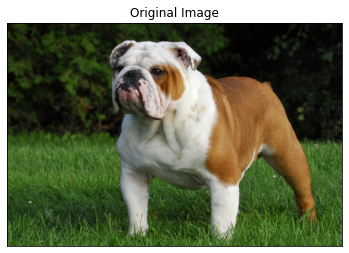

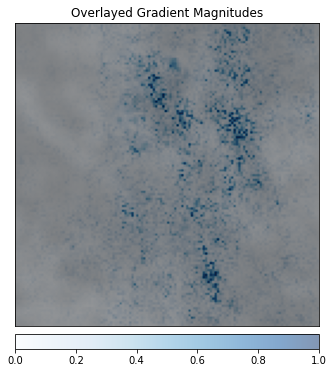

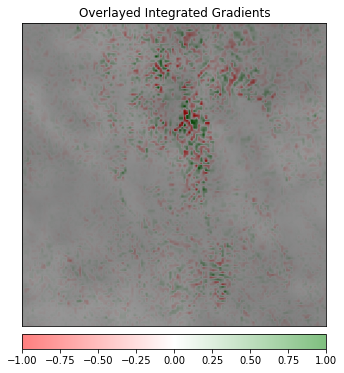

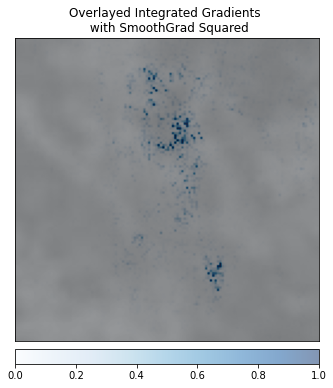

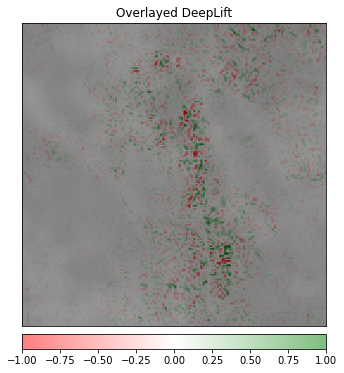

In [42]:
print('Original Image')
print('Predicted:', vgg19ClassList[indx], 
      ' Probability:', torch.max(F.softmax(scores, 1)).item())

trans1 = T.ToTensor()
tensorImg = trans1(img)

original_image = np.transpose((tensorImg.cpu().detach().numpy()), (1, 2, 0))


_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value", 
                             outlier_perc=10, show_colorbar=True, 
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True, 
                          title="Overlayed DeepLift")

### Homebrewed Softmax function

I don't know why I just wanted to know what the SoftMax function looked like, so here I made it... kinda.

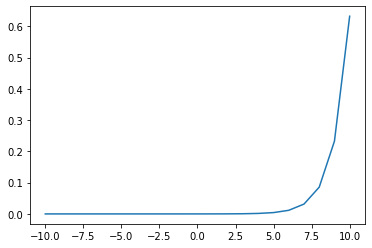

In [3]:
def softMax(numbers: list):
    from math import exp
    expSum = sum([exp(number) for number in numbers])
    softMaxOfNumbers = [exp(number)/expSum for number in numbers]
    
    return softMaxOfNumbers

numbies = list(range(-50,51))
softMaxOfNumbies = softMax(numbies)

plt.plot(numbies, softMaxOfNumbies)
    

#### Will propably never come in use
Some code I wrote which probably will never come in use again.

In [44]:
# This prooved to be quite useless
import difflib
nmbOfCloseMatches = 10
desiredLikeness = 0.6
closeMatches = difflib.get_close_matches('cat', vgg19ClassList, n=nmbOfCloseMatches, cutoff=desiredLikeness)
# print(closeMatches)